---
>「私は対象が見えるようにではなく、私が思うように描くのだ」
>
> ゴッホ
---

Diffusionモデルを利用し、入力テキストから画像を作成する

まずその動作を確認し、Diffusionモデルについて学ぶ

# Stable Diffusionとは？

2022年初めに提供されたテキストから画像への潜在的拡散モデル
- LAION-5Bデータベースのサブセットを用いて512x512の画像を生成するように学習されている
- テキストプロンプト入力を条件として、凍結されたCLIP ViT-L/14テキストエンコーダーを使用する
- 860MのUNetと123Mのテキストエンコーダを持っており、これでも比較的軽量で、10GBVRAMを持つGPUでも動作するため、コンシューマー向けのGPUで動作する
- Huggingfaceは数行のコードでテキストから画像への推論を実行するAPIを提供しており、これを利用する

## セットアップ

まずGPUランタイムを確認すること

コマンドが失敗する場合はメモリ不足の可能性があるため、ランタイムメニューを使い、ランタイムの種類を変更するとよい

`diffusers=0.2.4`と`scipy`、`ftfy`、`transformers`をインストールする

In [ ]:
#!pip install diffusers==0.8.0
!pip install diffusers transformers
!pip install --upgrade --pre triton
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == 

事前学習モデルをダウンロードして利用する前に、ライセンスに同意する必要がある

ここではモデルバージョン `v1-4` を使用する

- HuggingFaceのアカウントを作成する
  - HuggingFace ( https://huggingface.co/ ) にアクセスし画面右上のSignUpよりアカウントを作成
  - 登録したメールアドレス届く認証メールに記載されたリンクにアクセス
  - 以上でアカウント登録は完了

- https://huggingface.co/CompVis/stable-diffusion-v1-4 にアクセスしてライセンスを読み、同意するにチェックする

- コードを動作させるためのアクセストークンを取得する
  - 承認後、画面右上のアカウントのアイコンから[Settings]->[Access Tokens]に移動
  - NewTokenを発行し、メモする(コピーしておけばよい)
  - 後ほどwriteトークンが必要であるため、writeを発行すること  
  - 詳細は https://huggingface.co/docs/hub/security-tokens を参照すること

google colabは外部ウィジェットを無効にしているため、明示的に有効化する
- 次のセルを実行し`notebook_login`を使用できるようにする

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

この操作により、ユーザートークンを使ってログインできる
- 次を実行してコピーして置いたユーザートークンを入力する
- ここで一度実行が止まるが、トークを入力した後に、「以降のセルを実行」を選択して継続させること
-`git config --global credential.helper store`を実行するように促されるが Google Colabでは無視してよい

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Stable Diffusion Pipeline

`StableDiffusionPipeline` はエンドツーエンドの推論パイプラインである
- 簡単に試行できるように数行のコードでテキストから画像を生成できる

- モデルの全コンポーネントについて、事前学習モデルをロード

  - モデル ID CompVis/stable-diffusion-v1-4 ( https://huggingface.co/CompVis/stable-diffusion-v1-4 ) に加えて、特定の `revision`, `torch_dtype` と `use_auth_token` も `from_pretrained` メソッドに渡す

  - `use_auth_token`は、モデルのライセンスを本当に受け入れたかどうかを確認するために必要となる

  - Google Colabを用いた場合でも安定したDiffusionを実行できるようにFP16の半精度ブランチ( https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16 ) から重みをロードし、`diffusers` に `torch_dtype=torch.float16` を渡す

- 可能な限り高い精度を確保したい場合は、 `revision="fp16"` と `torch_dtype=torch.float16` を削除するとよい


In [ ]:
import torch
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis-

パイプラインをGPUに移行する

In [ ]:
pipe = pipe.to("cuda")

次に、「描画したい絵の説明」を「英語」で入力する。
  - なお、倫理的に不適切な画像を生成することができないようになっており、NSFW(Not Safe For Work)という警告と一緒に真っ黒な画像が生成される  
  これがどうやって判断されているかは不明
  - 公開モデルとするための障害はここにあるのではないかと考える
  - ちなみに、この機能は解除可能であり、シンプルにはsefety_check.pyを探し、NSFWを検索して該当部分をコメントアウトすればよい

例えば、

- "Detailing oil painting of three headed dog by Katsuhika Hokusai"
- "a photograph of an astronaut riding a horse"
- "a screenshot of kawaii packman game"
- "a old table game of packman"
- "a photograph of a cat riding a bicycle"
- "a photograph of a cat driving a car"
- "a photograph of a cat eating a burger"
- "a photograph of a cat eating udon"

In [ ]:
textin = "a photograph of a cat eating pizza in a garden"

実際に画像を生成する

`autocast`を用いると、推論が半精度で実行されるため処理時間が短縮できる

  0%|          | 0/50 [00:00<?, ?it/s]

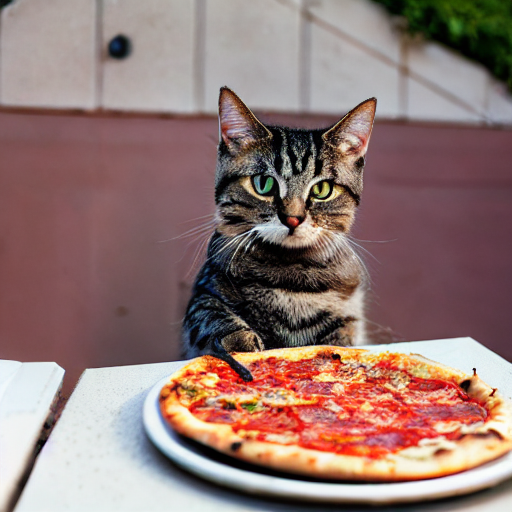

In [ ]:
from torch import autocast
prompt = textin
with autocast("cuda"):
  image = pipe(prompt)["images"][0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)
# Now to display an image you can do either save it such as:
image.save(f"result.png")
# or if you're in a google colab you can directly display it with
image

上記のセルは実行させるたびに異なる画像が生成する

生成画像を固定したい場合は、次のようにして乱数の種を固定する


In [ ]:
import torch
generator = torch.Generator("cuda").manual_seed(1024)
with autocast("cuda"):
  image = pipe(prompt, generator=generator)["images"][0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

パラメタ`num_inference_steps` を用いて推論ステップ数を変更できる

- ステップ数が多いほど生成画像の結果は良くなる
- Stable Diffusionは比較的小さなステップ数でも正しく生成でｋるため、デフォルトの50で実行することが推奨されている
- より速い結果を得たい場合は、より小さな数を使用するとよい

例を示そう
- 同じ乱数の種を使用して画像を生成しているが、ステップ数を15と少なくすると、細部をリアルに生成できない


  0%|          | 0/15 [00:00<?, ?it/s]

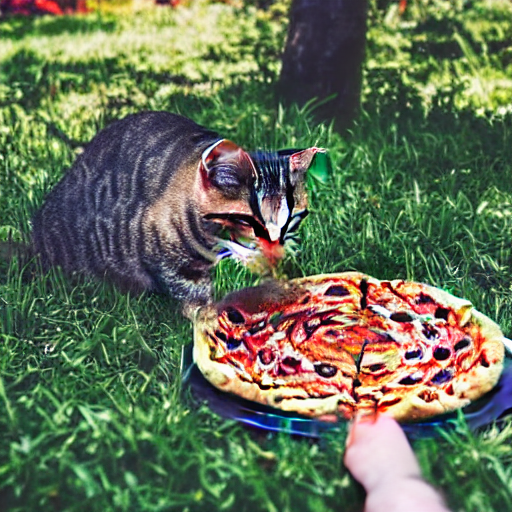

In [ ]:
import torch
generator = torch.Generator("cuda").manual_seed(1024)
with autocast("cuda"):
  image = pipe(prompt, num_inference_steps=15, generator=generator)["images"][0]
image

同様にパラメタ、`guidance_scale` を利用することで、分類器の利用程度を制御する
- 分類器の利用度合いが小さい場合は、テキストにマッチするようになる、つまりテキストなどの条件により従うようになる

- 7や8.5といった数値は良い画像を生成するが、極端に大きな値では、良い画像を生成するかもしれないが、多様性が欠けることになる

同一テキストで複数画像を生成するには、そのテキストを複数含むリストを使用すればよい

そこで、複数画像をグリッドを表示するためのヘルパー関数、`image_grid`関数を記述する

In [ ]:
from PIL import Image
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

3つのプロンプトのリストでパイプラインを実行すると、グリッド画像を生成できる

In [ ]:
num_images = 3
prompt = [textin] * num_images

with autocast("cuda"):
  images = pipe(prompt)["images"]

grid = image_grid(images, rows=1, cols=3)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

`n × m`のグリッドの画像を生成するには、次の通りにするとよい

In [ ]:
num_cols = 3
num_rows = 4
prompt = [textin] * num_cols
all_images = []
for i in range(num_rows):
  with autocast("cuda"):
    images = pipe(prompt)["images"]
  all_images.extend(images)
grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

Output hidden; open in https://colab.research.google.com to view.

## 長方形イメージの生成

Stable Diffusion は`512 × 512` ピクセルのイメージをデフォルトで生成する

- `height` と `width` 引数を使って生成画像のサイズを変更できる

以下に、画像サイズを指定する際の注意事項を列挙する
- `height` と `width` は共に8の倍数でなければならない
- 512以上が望ましい
  - 画像品質が低下する可能性がある
- 縦横ともに512を超えると画像領域が繰り返されるため、どちらかだけ拡張すること
  - グローバルコヒーレンスが失われる

要するに、正方形でない画像を作成する場合は、一方を`512`とし、もう一方のみそれよりも大きい値を使用するとよい

In [ ]:
prompt = textin
with autocast("cuda"):
  image = pipe(prompt, height=512, width=768)["images"][0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

# Diffusion(拡散)モデルとは?

画像を生成するモデルとして、VAEとGANについてこれまで学んだ

- GANは高精細な画像生成に適するが、学習が難しく、モード崩壊や勾配消失などの課題があるとともに、出力が多様性に欠ける
- VAEは理論的背景が比較的クリアであるが、損失関数の設計をどうするか、また、出力結果の品質がGANに比較して低い場合が多い

拡散モデルはVAEと同様の着想であるが、物理現象から着想を得た手法である
- 気体分子の熱力学に由来し、期待分子が高密度から低密度の領域へと拡散する動き(エントロピーの増加や熱死)を、情報理論におけるノイズ印加(情報損失)ととらえて、その逆変換を考える手法
- つまり、ノイズによる情報減衰を学習したモデルは、その処理を逆行させることで、ノイズから情報を回復させることができるはずという考え方
- VAEとの類似は、データを潜在空間に投影し、それを初期状態に戻すことで目的関数を最適化するという計算過程にある
  - 一方で、データ分布を学習せず、ノイズ分布をマルコフ連鎖でモデル化し、階層的にノイズを除去することでデータを復号化することを目的としている点に注意

# ノイズ除去拡散モデルとは?

ノイズ除去拡散モデルは、順方向拡散処理と逆方向拡散処理(再構成)の2つのステップで構成される
- 順方向拡散処理では、データが完全にノイズになるまでガウスノイズを順次導入する
  - Fowardはガウスノイズを固定でかけるだけにすることで、Foward側には学習パラメータをなくす
- 逆方向拡散過程では、DNNを用いて条件付き確率密度を学習しノイズを除去する
  - 画像生成時(reverse)の時は画像にかけられているノイズを推測して取り除いていく

図のように画像$X_0$に対してノイズを加えた画像$X_T$が存在するとき、このノイズを印加する順方向拡散処理(Forward Diffusion)に対する、逆変換としてのノイズを削除する逆方向拡散処理(Reverse Diffusion)処理を考える

- 順方向の変化量が十分に小さい場合、逆変換も同様のガウシアンで表せることがわかっている(コルモゴロフ)
- 従って、ForwardもReverseもガウス分布とすることで、ガウス分布の性質である、KLダイバージェンスが解析的に計算可能で平均と分散だけを推論すればよいという理論が利用できる(VAEと同様）
- Fowardでかけるノイズの分散は時刻tにより決まっているため、実際には平均だけを推論できればよい

この処理を一気に行うのではなく、少しだけノイズを除去する処理を繰り返すと考え、その順ノイズ印加の1変換を$q(x_t|x_{t-1})$、逆変換を$p_\theta (x_{t-1}|x_t)$とする

<img src="http://class.west.sd.keio.ac.jp/dataai/text/diffusion-org.png" width="500">

<img src="http://class.west.sd.keio.ac.jp/dataai/text/diffusionmodelprocesseq.png" width="800">


## 順方向処理

前方拡散処理はマルコフ連鎖として定義できるため、VAEにおけるエンコーダとは異なり学習モデルを利用する必要がない
- 初期データ点から始めて、$T$ステップ連続してガウスノイズを加え、ノイズが加わった画像のサンプル集合を得る
- 時刻$t$における確率密度予測は、直前つまり時刻$t-1$のデータにのみ依存する

従って、ステップ1つは次のように表記できる
- $\mathbf{x}_{t-1}$から$\mathbf{x}_t$に変換するために加えるガウスノイズは、ノイズの強さ$\beta_t$とすると、平均$\sqrt{1-\beta_t}x_{t-1}$、分散$\beta_t I$であることから次のように表すことができる  
$$q(\mathbf{x}_t|\mathbf{x}_{t-1})= \mathcal{N}(\mathbf{x}_t;\sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t \mathbf{I}) $$

- その全ステップは次のようになる  
$$q(\mathbf{x}_{1:T}|\mathbf{x}_0)=\prod^T_{t=1}q(\mathbf{x}_t|\mathbf{x}_{t−1})$$

- さらに、ハイパーパラメータ$\alpha_T = 1-\beta_{T}$とすると次のように変形できる  
$$\mathbf{x}_t = \sqrt{\alpha_{t}}\mathbf{x}_{t−1}+\sqrt{1−\alpha_{t}}\mathbf{z}_{t−1}$$  
  さらに、複数のガウシアンの融合を$\bar{\mathbf{z}}$とすると  
$\mathbf{x}_t = \sqrt{\alpha_{t}\alpha_{t_1}}\mathbf{x}_{t−2}+\sqrt{1−\alpha_{t}\alpha_{t-1}}\bar{\mathbf{z}}_{t−2}$  
  最終的に  
$\mathbf{x}_t = \sqrt{\bar{\alpha}}\mathbf{x}_0+\sqrt{1−\bar{\alpha}_{t}}\mathbf{z}$  
  となることから、  
$$q(\mathbf{x}_t|\mathbf{x}_0)= \mathcal{N}(\mathbf{x}_t;\sqrt{\bar{\alpha}}\mathbf{x}_0, (1-\bar{\alpha}_{t}) \mathbf{I}) $$
  と表せる

時刻$t-1$で得られる確率密度推定値を用いて時刻$t$の状態を生成するには、熱力学の別の概念である「ランジュバン動力学」を用いる
- 確率勾配ランジュバン動力学では、マルコフ連鎖更新における密度関数の勾配によって、システムの新しい状態を生成できる
- 時刻$t-1$でのステップサイズ$\varepsilon$、時刻$t$での新しい状態は次のようになる  
$$x_t = x_{t-1}+\frac{\varepsilon}{2}\nabla_x p(x_{t-1})+\sqrt{\varepsilon}z_i$$

## 再現の方法

現在の状態から、それ以前の時間ステップにおける確率密度を推定する
- つまり、$t=T$のときの$q(x_{T-1}|x_T)$を推定し、ガウスノイズから元のデータを生成する

この生成には、そのような推定値を予測できる学習モデルが必要となる
- そこで、学習した重み$\theta$と時刻$t$における現在の状態から$\rho \theta (x_{T-1}|x_T)$を推定するDNNを用いて次のように学習させる

$$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

$$p_\theta(x_{0;T}) = p(x_T)\prod^T_{t=1}p_\theta(x_{t-1}|x_t)$$

平均関数のパラメータ化は以下のように計算できる

$$\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\varepsilon_\theta(x_t, t))$$

さらに、この計算において、$\sum \theta = \beta T$としてた固定分散関数の使用が提案されており、これに基づくと、時刻$t-1$の標本は以下のように計算できる

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\varepsilon_\theta(x_t, t))+\sigma_t
z$$  
$$z\sim \mathcal{N}(\mathbf{O},\mathbf{I}) $$



##  モデルの構築

VAEネットワークと同様である
- 入力層はデータ次元と同じ入力サイズを持つ
- 隠れ層は一般に活性化関数を持つ線形層で構成される
- 最終層は再び元の入力層と同じ大きさとし、元のデータが再構成される

ノイズ除去拡散ネットワークの最終層は2つの別々の出力からなり、それぞれ予測された確率密度の平均と分散となる

## 損失関数の計算

ネットワークモデルの目的は、損失関数を最適化することであるが、その関数は次のような式となる
- 2つのガウス分布間のKLダイバージェンスとエントロピーの線形結合とする
- この形であれば計算を単純化でき、実装が容易になる

$$\mathcal{L}=-\mathbb{E}_{t, x_0, \varepsilon}(||\varepsilon-\varepsilon_\theta(\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha}_t\varepsilon, t)||^2)$$

# Latent Diffusion Model(潜在拡散モデル)とは?

その特徴は次の通り
- Latent Diffusion Models(LDM)はDiffusion Modelsをベースとしている
- VAEを適用し画像は、高次元な$\mathbf{x}$から低次元な潜在表現$\mathbf{z}$にエンコードされ、Diffusion Process全体での計算量を削減する
  - つまり画像のまま進めない
- テキストなど条件付き画像生成の精度を高めるためU-Netベースのクロスアテンションを導入

これらの既存手法の組み合わせで構成されている

全体像は次の通り

<img src="http://class.west.sd.keio.ac.jp/dataai/text/latent-diffusion-model.png" width="800">



## Stable Diffusion

Stable Diffusion(安定拡散法)は、上記潜在拡散モデルを拡張している

- Stable Diffusionは、"High-Resolution Image Synthesis with Latent Diffusion Models"という論文( https://arxiv.org/abs/2112.10752 )で提案された Latent Diffusion という特殊な拡散モデルを利用する
- これを安定的に動作させ、API化したモデルで、huggingfaceにより提供されている

以下、Latenet DiffusionとStable Diffusionの両方に共通する事項が多いため、まとめて説明する

## ここまでの流れとStable Diffusion

拡散モデルは、ランダムなガウスノイズを段階的に除去するように訓練され、これをうまく利用すれば狙った画像を生成できる
- 利点
  - 拡散モデルは、画像データの生成において、詳細かつ細部が整った美しい画像を得ることができる
- 欠点
  - ノイズ処理に時間がかかる
  - ピクセル空間で動作するため多くのメモリを消費し、高解像度の画像を生成する際のコストが大きい

潜在拡散(Latent Diffusion)モデルはこれらの問題を解決した
- 実際のピクセル空間を使用せず、より低次元である潜在空間上で拡散プロセスを適用することで、メモリと計算の複雑さを軽減
- 潜在拡散では、モデルは画像の潜在表現、つまり圧縮表現を生成するように学習

潜在拡散には次の3つの主要技術要素が利用されている
1. 変分的オートエンコーダ(VAE)
1. U-Net (https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq)
1. テキストエンコーダー
  - 例としてCLIPのテキストエンコーダー(https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel)がある

VAEとU-NETは既に取り扱ったことがあるが、改めて概説する

## Variational Autoencoder（VAE）

これは既習済である

VAEモデルは、エンコーダーとデコーダーの2つの部分から構成されており、エンコーダは画像を低次元の潜在表現に変換、デコーダはその潜在表現を画像に戻すように学習される

Diffuserでは、U-Netモデルの入力に変換するために用いられる

潜在拡散モデルを学習する際、エンコーダは順方向拡散処理に用いる画像の潜在表現を得るために用いられる
- このエンコーダの各ステップにおいて、次々とノイズが加えられる
- 推論では逆拡散処理で生成された潜在情報をVAEデコーダで再び画像に変換する
- 推論時に必要なのはVAEデコーダのみである

## U-Net

これも詳細は説明していないが、Style Transferなどで既に取り上げている

U-NetはResNetブロックで構成されるエンコーダ部とデコーダ部を持つモデルである

エンコーダは画像表現を低解像度画像表現に圧縮し、デコーダは低解像度画像表現をノイズが少ない高解像度画像表現に復号する
- つまり、U-Netの出力によりノイズ残差を予測できるため、予測されたノイズ除去画像表現の計算に利用できる

U-Netがダウンサンプリング中に重要な情報を失わないよう、エンコーダのダウンサンプリングResNetsとデコーダのアップサンプリングResNetsの間にショートカット接続が追加されている

潜在拡散モデルでは、cross-attention層を介して、テキストエンベディングを条件として出力を行うことができるように拡張された安定拡散U-Netが用いられている
- cross-attention layerは、U-Netのエンコーダ部とデコーダ部のResNetブロックの間に追加されている

## テキスト・エンコーダ

入力されたテキストをU-Netで利用可能な埋め込み空間(embedding space)に変換する
- つまり、テキストから生成される入力トークン列を潜在的なテキスト埋め込みにマッピングする変換器である

Stable Diffusion では学習中にテキストエンコーダの学習は行わず、学習済みのテキストエンコーダ CLIPTextModel を利用する

## なぜ潜像拡散は高速で効率的なのか？

潜在拡散モデルのU-Netは低次元空間上で動作するため、ピクセル空間上の拡散モデルよりもメモリや計算量を大幅に削減できる

例えば、Stable Diffusionのオートエンコーダーは縮小率が8であることから、フルカラー `(3, 512, 512)` の画像が、潜像空間では `(3, 64, 64)` に縮約されている
- つまり、メモリ消費量は 1/64 まで削減できる
- 処理遅延も低減できる

## 推論時の安定拡散について

安定拡散モデルは、潜在シード(Latent seed)とテキストプロンプトを入力とする
- 潜在シードから$64 \times 64$のランダムな潜在画像表現を生成し、テキストプロンプトは、CLIPのテキストエンコーダーにより$77 \times 768$のEmbedded space(テキスト埋め込みとしよう)に変換される

U-Netはテキスト埋め込みを条件として、ランダムな潜像表現からノイズを除去する
- 既に述べた通り、U-Netの出力は、ノイズ残差であり、スケジューラアルゴリズムを介してノイズ除去された潜像表現を計算するために使用する
  - スケジューラアルゴリズムは、元のノイズ表現と予測されるノイズ残差から予測されるノイズ除去画像表現を計算するために利用する
  - 様々なスケジューラアルゴリズムを利用でき、それぞれ長所と短所がある
  - Stable Diffusionでは、以下のいずれかの利用が推奨されている
  
- PNDMスケジューラ]  
(https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (デフォルトで使用)
- DDIMスケジューラ]  
(https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- K-LMSスケジューラ]  
(https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)

ノイズ除去処理を約50回繰り返し、よりよい潜在表現を段階的に生成し、最終的に得られた潜像表現を用いてVAEのデコーダ部によって復号する

その全体構造は次の通り

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stable_diffusion.png" width="500">


なお、実際にはテキストだけでなく、
```
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=access_tokens
).to("cuda")

init_image = Image.open(filename)
if '.png' in filename:
  init_image = init_image.convert('RGB')
resize_image = init_image.resize((768, 512))
input_img = preprocess(resize_image)

with autocast("cuda"):
  images = pipe(
      prompt=prompt, init_image=input_img,
      strength=0.75, guidance_scale=7.5,
      num_inference_steps=51, generator=generator,)["images"]
```
とすることで、ある画像を初期画像として、テキストに合わせた画像に変換するといった芸当も可能である

# Diffusers について

Diffuserモデル(拡散モデル)は、人工的なデータ合成に有効な手法である
- 特に画像生成モデルとして著名なGANにも匹敵する
- テキストから画像を生成するDALL-E2(https://openai.com/dall-e-2/) や GoogleのImagen(https://imagen.research.google/) でも利用されている

拡散モデルは画像以外でも、音声合成や強化学習で用いられる
- 動画像生成](https://video-diffusion.github.io/),
- 音声合成](https://diffwave-demo.github.io/)。
- 強化学習](https://diffusion-planning.github.io/)。

DALL-E2や Imagen などは、そのモデル利用が制限されているが、Diffuersは、オープンなモデルであるため、これを利用する
- ここでは、Huggingfaceのモデル、またAPIを利用する
- 自身の独自モデルを学習させる、他のリポジトリから学習済モデルを利用するなどが容易なAPIである

ここでは、この`diffusers` のAPIを使いながらその動作について述べる

その構成は次の通り

1. Pipelines: 一般的な拡散モデルからサンプルを生成するための高レベルなクラス
1. Models: 新しい拡散モデルを学習するための一般的なアーキテクチャで、例えば UNET
1. スケジューラ: ノイズから画像を生成するための様々なテクニック

まず拡散モデルの推論について説明し、後ほど拡散モデルの学習について説明する


関連資料として以下が挙げられる

- [OpenAI入門記事](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
- [Diffuser 紹介記事](https://yang-song.github.io/blog/2021/score/)
- [注釈付き拡散モデル](https://huggingface.co/blog/annotated-diffusion)
- [教師なし学習のための熱力学](https://arxiv.org/abs/1503.03585)
- 普及型拡散モデル[Denoising Diffusion Probabilistic Models DDPM](https://arxiv.org/abs/2006.11239)
- [拡散モデルにおけるトレードオフ](https://arxiv.org/abs/2206.00364)

### 概要

拡散モデルは、ランダムなガウスノイズを段階的に除去するように訓練された機械学習システムであることは既に述べた

このモデルは、各ステップで画像からノイズ除去するように学習されている
- あるステップ数のノイズ除去処理を施した後にサンプル画像を得ることができる
- 処理内容のイメージは次の通り

<img src="http://class.west.sd.keio.ac.jp/dataai/text/diffusion-process.png">

### UNet

既にStyle Transferでも説明済であるが、簡単に復習する

- Unetは入力と同じ大きさの画像を予測するAutoEncoderである
- Unetは、入力画像を画像サイズを2分の1にするResNet層ブロック複数個並べた構造を持つ
- エンコーダとデコーダは同じ数のResNet層ブロックを持っており、デコーダにより再びアップサンプリングされる
- スキップ接続は、ダウンサンプル経路の特徴をアップサンプル経路の対応する層にリンクさせる機能をもつ(スキップ接続)
- 入力と同じサイズの画像を出力する

ほとんどの拡散モデルは、U-netに準拠したモデルを利用しており、ここでもU-netを用いる

Diffusersの`UNet2DModel`クラスを用いてモデルを構築する

モデルは次の図の通りである
- `down_block_types`: ダウンサンプリングブロック（図の緑）
- `up_block_types`はアップサンプリングブロック（図の赤）


<img src="http://class.west.sd.keio.ac.jp/dataai/text/unet-model.png">

拡散処理は、出力画像と同じ大きさのランダムなノイズ画像をモデルに入力し、ノイズから目的の画像へ徐々に変換する処理である

- 出力画像は学習画像に従い、ここでは例として蝶のデータセットを用いるため蝶の画像となる
- 学習では、ここでは蝶の画像を多数準備して入力する
- 学習させることで、モデルはランダムなノイズを処理して、様々な蝶の画像を生成できるようになる

モデルは直接的にノイズの少ない画像を予測していないことに注意する
- ノイズの少ない画像と入力画像の差である「ノイズ残差」（拡散モデルではDDPMと呼ぶ）や、2つの時間ステップ間の勾配（拡散モデルでは「Score VE」と呼ぶ）を予測するように訓練される

ノイズ除去には特定のノイズスケジューリングアルゴリズムが必要
- モデルの出力からノイズの少ない画像を計算する別の方法が必要
- 推論に必要な拡散処理のステップ数を管理するため、モデルの入力としてステップ数を纏めて扱う



from_pretrained()メソッドを利用し、モデルの設定と重みをロードして実際のネットワーク構造を確認する

In [ ]:
from diffusers import UNet2DModel
repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)
model

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

An error occurred while trying to fetch google/ddpm-church-256: google/ddpm-church-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

モデルの設定についてもconfig属性を用いて確認する

次のようなパラメタが含まれる
- image_size: 入力サンプルの高さと幅の寸法
- in_channels: 入力サンプルの入力チャンネル数
- down_block_typesとup_block_types：UNetアーキテクチャを作成するために使用するダウンサンプリングとアップサンプリングのブロックの種類
- block_out_channels: ダウンサンプリングブロックの出力チャンネル数および、アップサンプリングブロックの入力チャンネル数
- layers_per_block: 各UNetブロックに存在するResNetブロック数

In [ ]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'si

モデル・アーキテクチャをランダムな重みでインスタンス化する

In [ ]:
model_random = UNet2DModel(**model.config)

このモデルを推論に使用する

- batch_size × in_channels(RGB) × image_size(縦) × image_size(横)の形をしたランダムガウス標本としての画像を準備する
- モデルはわずかにノイズの少ない画像、わずかにノイズの少ない画像と入力画像との差を予測し、これを繰り返す

In [ ]:
import torch
torch.manual_seed(0)
noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

少しノイズの少ない画像を求める
- なおサイズは変化しない

In [ ]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample
noisy_residual.shape

torch.Size([1, 3, 256, 256])

これを繰り返せばよいが、実際にはスケジューラーを組み合わせて、実際に画像を生成できるようにする

In [ ]:
from diffusers import DDPMScheduler
scheduler = DDPMScheduler.from_config(repo_id)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

configは次のとおりである

代表的なパラメタは次のとおりである
- num_train_timesteps: ノイズ除去処理の長さ
  - ランダムなガウスノイズをデータサンプルに処理するのに必要なタイムステップ数
- beta_schedule: 推論と学習に使用されるノイズスケジュールの種類
- beta_startとbeta_end: スケジュールの最小ノイズ値と最大ノイズ値

In [ ]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 0),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['timestep_spacing',
              'thresholding',
              'steps_offset',
              'sample_max_value',
              'prediction_type',
              'dynamic_thresholding_ratio',
              'rescale_betas_zero_snr',
              'clip_sample_range']),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_versi

スケジューラのsetp()メソッドは、わずかにノイズの少ない画像を求める処理を実施する

In [ ]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

すべてをまとめて、実際にノイズ除去ループを定義する
- ここでは途中の結果を可視化し、徐々にノイズが少なくなる様子を観察する

まずは、その可視化関数を定義する

In [ ]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

モデルをGPUに移す

In [ ]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

次の、ノイズ除去ループを繰り返す

- モデルでノイズの少ないサンプルの残差を予測
- スケジューラでノイズの少ないサンプルを計算
- 50ステップごとに進捗を表示

ノイズから徐々に協会の絵が生成されるであろう

In [ ]:
import tqdm
sample = noisy_sample
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample
  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample
  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

Output hidden; open in https://colab.research.google.com to view.

ある程度意味のある形状を見るには、かなりの反復数(800ステップ程度)必要となる
- 画像の品質はよいが、画像生成の速度は満足できるとはいえない
- そこで、DDPMスケジューラをDDIMスケジューラに置き換えることで、高い生成品質を維持したまま、生成時間を大幅に短縮する

In [ ]:
from diffusers import DDIMScheduler
scheduler = DDIMScheduler.from_config(repo_id)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


DDIMでは、推論ステップを1000から50に減らして実行してみる

 18%|█▊        | 9/50 [00:01<00:04,  8.32it/s]

'Image at step 10'

 38%|███▊      | 19/50 [00:02<00:03,  8.07it/s]

'Image at step 20'

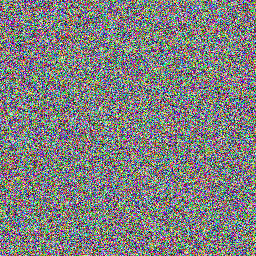

 58%|█████▊    | 29/50 [00:03<00:02,  8.06it/s]

'Image at step 30'

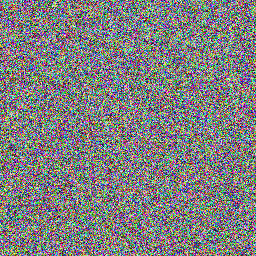

 78%|███████▊  | 39/50 [00:04<00:01,  7.99it/s]

'Image at step 40'

 98%|█████████▊| 49/50 [00:06<00:00,  8.08it/s]

'Image at step 50'

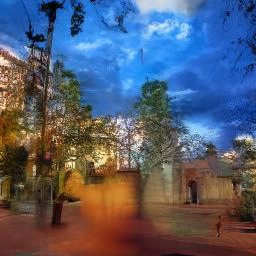

100%|██████████| 50/50 [00:06<00:00,  7.89it/s]


In [ ]:
scheduler.set_timesteps(num_inference_steps=50)
import tqdm
sample = noisy_sample
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample
  # 2. compute previous image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample
  # 3. optionally look at image
  if (i + 1) % 10 == 0:
      display_sample(sample, i + 1)

画像生成は高速化できたが、画質が犠牲となったことがわかる


## 拡散モデルのインパクト

2022年はDALL･E 2、Stable Diffusion、Imagenなど高性能な画像生成AIが多く登場し話題となった

- これらはすべて生成器に拡散モデルを採用している点で共通

- 2021年頃から拡散モデルがGANに取ってかわる動きがあり、その後の1年で決着が付いたと言える
  - text-to-imageのテキストエンコーダ部分を大きくすることで、生成品質を保ちながら入力テキストにより忠実な画像の生成を可能にした
    - 画像の品質（低いほど良い）と入力テキストとの整合性（高いほど良い）のトレードオフや、画像の品質（低いほど良い）と入力テキストへの忠実さ（高いほど良い）のトレードオフについて、生成器を大きくするよりもテキストエンコーダを大きくする方がより効果的であることが示されている
    
- 拡散モデルの最大の弱点は、生成に1000回程度の推論が必要なため時間がかかるという点

  - 推論回数を減らす工夫として、微分方程式を利用した手法、拡散モデルを訓練・ネットワーク・サンプリングの3モジュールに分解して再設計した手法などがあり、Stable Diffusionで採用されている


# 課題1
- とにかくも、text2imageで遊んでみよう
  - このノートブックを利用する場合は、アカウントの登録とトークンの取得が必要です
  - このノートブック以外のtext2imageでも構いません
- AIと倫理問題について考えてみよう
- デフューザーを訓練して自分なりの画像生成モデルを作成しなさい
  - 例えばラーメン、自動車、本など、データが取得しやすい対象が良いであろう

# 課題2

ここで利用しているのは2022年12月時点で最新のdiffusersバージョン0.9である
- 高解像度化されているので試してみよう
- `You must restart the runtime in order to use newly installed versions.`というエラーが発生した場合は、「再起動して全てのセルを実行」を選択し、再実行すること

xformersのインストールをインストールする所だが、Google Colabではwheelによるインストールのためエラーとなる
```
!pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various_6/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl
```
Xformersを導入すると使用するメモリが減る上に高速化できる
- デメリットとして若干生成される画像が毎回変化する


パイプラインの準備

In [ ]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

# パイプラインの準備
model_id = "stabilityai/stable-diffusion-2"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=EulerDiscreteScheduler.from_pretrained(
        model_id,
        subfolder="scheduler"
    ),
    torch_dtype=torch.float16,
    revision="fp16"
).to("cuda")
pipe.enable_attention_slicing()

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


推論の実行

In [ ]:
# 推論の実行
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt, height=768, width=768).images[0]
# 保存と表示
image.save("output.png")
image

  0%|          | 0/50 [00:00<?, ?it/s]

# チェックポイント

一度ここで中断し、次のセルから再度実行すること

In [ ]:
#from google.colab import runtime
#runtime.unassign()

# CLIP Interrogator

よりリアルな新しい画像を生成AIを用いて作成するためのプロンプトを生成



このバージョンは、Stable Diffusionで使用するプロンプトの生成に特化しており、生成されたテキストプロンプトとソース画像の間の高い位置合わせを実現します。異なるCLIPモデルがどのように用語をランク付けするかを確認するために、古いバージョン1を試すことができます。

また、HuggingFaceとReplicateでこれを実行することもできる。


## BLIP

BLIPとは Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation の略であり、このBLIPがClip-interrogatorでは利用されている

その特徴は、次の2つを備えること
- MED(Multimodal mixture of Encoder-Decoder)  
3つのVL(Vision-Language)事前学習タスクを行うUnimodalとMultimodalの混合アーキテクチャー
- CapFilt(Captioning and Filtering)  
ノイズはVLモデルにとって大きな問題となるため、ノイズの多いウェブ画像から合成キャプションを生成するモジュールと元のウェブテキストと合成テキストの両方からノイズの多いキャプションを除去するフィルタモジュール
- Image EncoderとしてVit、Text EncoderとしてBERTを利用
- ロスとして、Image-Text Contrastive Loss、Image-Text Matching Loss、Language Modeling Lossを併用
- 各タスクに固有の特殊トークン、[CLS], [Encode], [Decode]をBERTの先頭に挿入し、Masked Language Modelingを使用せず、通常のLanguage Modelingを使用することで視覚情報を一貫性のあるキャプションに変換する汎化能力を備えるようにしている

## Captioner (Cap)

合成キャプションを生成するためにキャプション作成ツール(Cap) を使い、ノイズの多いキャプションを除去

<img src="http://class.west.sd.keio.ac.jp/dataai/text/BLIP1.jpg" width=600>


## 事前学習モデルのアーキテクチャ

次の図において、同じパラメータは同じ色で表記している

エンコーダとデコーダのマルチモーダル混合を図るため、
- ユニモーダルエンコーダは、視覚と言語表現を整合させるために、画像-テキスト対照(ITC)損失で学習
- イメージ・テキスト・エンコーダは、視覚と言語表現を整合させるため画像-テキストマッチング(ITM)損失で学習し、画像-テキストペアの正負を区別する
- 画像に基づくテキストデコーダは、双方向自己注意層を因果的自己注意層に置き換え、エンコーダと同じクロスアテンションレイヤーとフィードフォワードネットワークを共有、言語モデリング（LM）ロスで学習され、画像からキャプションを生成する。

<img src="http://class.west.sd.keio.ac.jp/dataai/text/BLIP2.jpg" width=800>

## 事前学習の手順

ウェブ画像の合成キャプションを生成するキャプション作成器と、ノイズの多い画像とテキストのペアを除去するフィルタは、同じ事前学習済みモデルで初期化しておき、小規模な人間による注釈付きデータセットで個別に微調整する

ブートストラップされたデータセットは、新しいモデルの事前学習に用いられる。

学習には次のステップを踏む
- 大量のWeb画像を用いてMEDを事前学習させる
- COCOを用いて各タスクをFineTuningする
- Web画像とテキストのペアをもつデータセットにより、Web画像から生成されたキャプションのペアをITMを用いてマッチしているか確認
  - マッチした場合はこれをDiscremenatorに加えて学習を繰り返す

<img src="http://class.west.sd.keio.ac.jp/dataai/text/BLIP3.jpg" width=800>


clip_model_nameについて、Stable Diffusion 1.XではViT-Lモデルを、Stable Diffusion 2.0+ではViT-H CLIPモデルを選択するとよい
- clip_model_name = 'ViT-L-14/openai'
- clip_model_name = 'ViT-H-14/laion2b_s32b_b79k'

基本関数を定義する

In [ ]:
import os, subprocess

def setup():
    install_cmds = [
        ['pip', 'install', 'gradio'],
        ['pip', 'install', 'open_clip_torch'],
        ['pip', 'install', 'clip-interrogator'],
    ]
    for cmd in install_cmds:
        print(subprocess.run(cmd, stdout=subprocess.PIPE).stdout.decode('utf-8'))

setup()


caption_model_name = 'blip-large'
clip_model_name = 'ViT-L-14/openai'

import gradio as gr
from clip_interrogator import Config, Interrogator

config = Config()
config.clip_model_name = clip_model_name
config.caption_model_name = caption_model_name
ci = Interrogator(config)

def image_analysis(image):
    image = image.convert('RGB')
    image_features = ci.image_to_features(image)

    top_mediums = ci.mediums.rank(image_features, 5)
    top_artists = ci.artists.rank(image_features, 5)
    top_movements = ci.movements.rank(image_features, 5)
    top_trendings = ci.trendings.rank(image_features, 5)
    top_flavors = ci.flavors.rank(image_features, 5)

    medium_ranks = {medium: sim for medium, sim in zip(top_mediums, ci.similarities(image_features, top_mediums))}
    artist_ranks = {artist: sim for artist, sim in zip(top_artists, ci.similarities(image_features, top_artists))}
    movement_ranks = {movement: sim for movement, sim in zip(top_movements, ci.similarities(image_features, top_movements))}
    trending_ranks = {trending: sim for trending, sim in zip(top_trendings, ci.similarities(image_features, top_trendings))}
    flavor_ranks = {flavor: sim for flavor, sim in zip(top_flavors, ci.similarities(image_features, top_flavors))}

    return medium_ranks, artist_ranks, movement_ranks, trending_ranks, flavor_ranks

def image_to_prompt(image, mode):
    ci.config.chunk_size = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existin

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Loading CLIP model ViT-L-14/openai...


100%|███████████████████████████████████████| 933M/933M [00:15<00:00, 59.7MiB/s]
ViT-L-14_openai_artists.safetensors: 100%|██████████| 16.2M/16.2M [00:00<00:00, 145MB/s]
ViT-L-14_openai_flavors.safetensors: 100%|██████████| 155M/155M [00:00<00:00, 221MB/s]
ViT-L-14_openai_mediums.safetensors: 100%|██████████| 146k/146k [00:00<00:00, 8.76MB/s]
ViT-L-14_openai_movements.safetensors: 100%|██████████| 307k/307k [00:00<00:00, 8.80MB/s]
ViT-L-14_openai_trendings.safetensors: 100%|██████████| 111k/111k [00:00<00:00, 5.95MB/s]
ViT-L-14_openai_negative.safetensors: 100%|██████████| 63.2k/63.2k [00:00<00:00, 5.24MB/s]

Loaded CLIP model and data in 28.49 seconds.


画像からプロンプトに変換する

In [ ]:
def prompt_tab():
    with gr.Column():
        with gr.Row():
            image = gr.Image(type='pil', label="Image")
            with gr.Column():
                mode = gr.Radio(['best', 'fast', 'classic', 'negative'], label='Mode', value='best')
        prompt = gr.Textbox(label="Prompt")
    button = gr.Button("Generate prompt")
    button.click(image_to_prompt, inputs=[image, mode], outputs=prompt)

def analyze_tab():
    with gr.Column():
        with gr.Row():
            image = gr.Image(type='pil', label="Image")
        with gr.Row():
            medium = gr.Label(label="Medium", num_top_classes=5)
            artist = gr.Label(label="Artist", num_top_classes=5)
            movement = gr.Label(label="Movement", num_top_classes=5)
            trending = gr.Label(label="Trending", num_top_classes=5)
            flavor = gr.Label(label="Flavor", num_top_classes=5)
    button = gr.Button("Analyze")
    button.click(image_analysis, inputs=image, outputs=[medium, artist, movement, trending, flavor])

with gr.Blocks() as ui:
    with gr.Tab("Prompt"):
        prompt_tab()
    with gr.Tab("Analyze"):
        analyze_tab()

ui.launch(show_api=False, debug=False)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5e891e07ed63f53216.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
